In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from models.utils.bayesian_module import BayesianModule, ConsistentMCDropout
from models.resnet_mcdropout import train_one_epoch

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


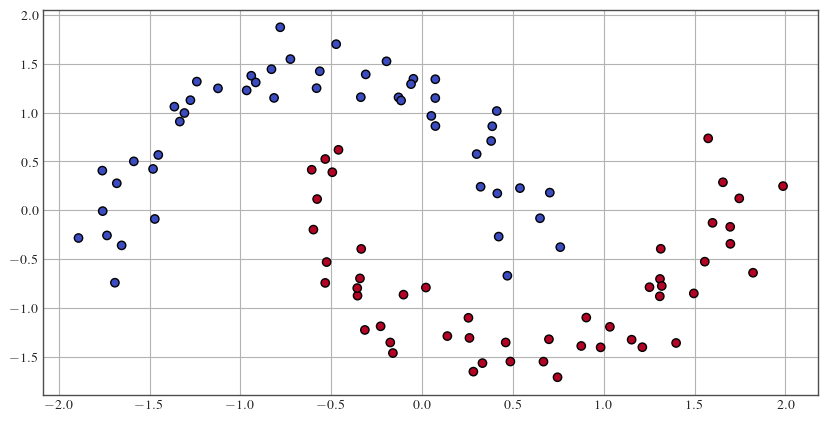

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [6]:
class MCDropoutNet(BayesianModule):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = ConsistentMCDropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = ConsistentMCDropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

    def mc_forward_impl(self, x):
        return self.forward(x)

In [7]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.mc_forward(zz, 100)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Training: Epoch 0  [0/1]  eta: 0:00:00  lr: 0.01  loss: 0.7193 (0.7193)  acc1: 55.0000 (55.0000)  time: 0.0020  data: 0.0006  max mem: 0
Training: Epoch 0 Total time: 0:00:00
Training: Epoch 1  [0/1]  eta: 0:00:00  lr: 0.01  loss: 0.6803 (0.6803)  acc1: 52.0000 (52.0000)  time: 0.0016  data: 0.0005  max mem: 0
Training: Epoch 1 Total time: 0:00:00
Training: Epoch 2  [0/1]  eta: 0:00:00  lr: 0.01  loss: 0.6896 (0.6896)  acc1: 54.0000 (54.0000)  time: 0.0014  data: 0.0004  max mem: 0
Training: Epoch 2 Total time: 0:00:00
Training: Epoch 3  [0/1]  eta: 0:00:00  lr: 0.01  loss: 0.6742 (0.6742)  acc1: 60.0000 (60.0000)  time: 0.0015  data: 0.0006  max mem: 0
Training: Epoch 3 Total time: 0:00:00
Training: Epoch 4  [0/1]  eta: 0:00:00  lr: 0.01  loss: 0.6474 (0.6474)  acc1: 61.0000 (61.0000)  time: 0.0014  data: 0.0004  max mem: 0
Training: Epoch 4 Total time: 0:00:00
Training: Epoch 5  [0/1]  eta: 0:00:00  lr: 0.01  loss: 0.6322 (0.6322)  acc1: 63.0000 (63.0000)  time: 0.0014  data: 0.0004 

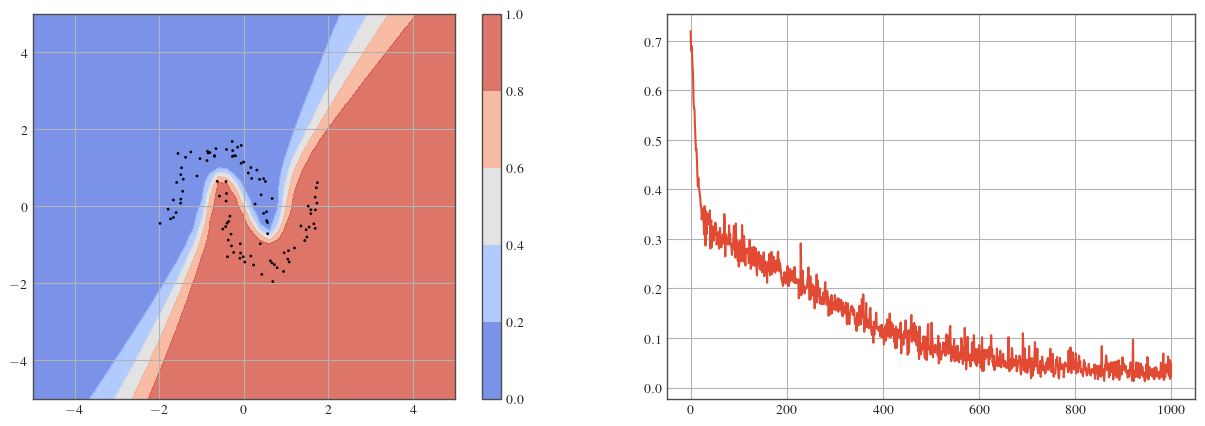

In [9]:
dropout_rate = 0.5
optimizer_params = dict(
    lr=1e-2,
    weight_decay=0,
    momentum=.9,
)
epochs = 1000
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = MCDropoutNet(dropout_rate=dropout_rate, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
criterion = nn.CrossEntropyLoss()
history = []
for i in range(epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
    history.append(train_stats)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()